In [16]:
import pandas as pd
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

FILE_PATH = 'flood_CHA.csv'
COLUMN_TO_FIT = 'Total Affected'
PERCENTILE_THRESHOLD = 0.95


df = pd.read_csv(FILE_PATH)
print(f"成功加载文件: {FILE_PATH}")

data_series = df[COLUMN_TO_FIT].copy()
data_series_numeric = pd.to_numeric(data_series, errors='coerce')

nan_count = data_series_numeric.isnull().sum()
if nan_count > 0:
    data_series_numeric.dropna(inplace=True)

if data_series_numeric.empty:
    exit()

original_count = len(data_series_numeric)
data_positive = data_series_numeric[data_series_numeric > 0]
removed_zeros_negatives = original_count - len(data_positive)

if data_positive.empty:
   exit()

print(f"\n用于计算百分位数的正数据点数量: {len(data_positive)}")

if len(data_positive) < 2:
    data_to_fit = data_positive.copy()
else:
    cutoff_value = data_positive.quantile(PERCENTILE_THRESHOLD)
    data_to_fit = data_positive[data_positive <= cutoff_value].copy()
    num_removed_by_percentile = len(data_positive) - len(data_to_fit)

data_to_fit = data_to_fit/10000
if data_to_fit.empty:
    exit()


成功加载文件: flood_CHA.csv

用于计算百分位数的正数据点数量: 263


筛选后数据的描述:
count     249.000000
mean      197.082908
std       489.738169
min         0.000700
25%         2.800000
50%        15.003000
75%       100.000000
max      3365.202600
Name: Total Affected, dtype: float64

开始对筛选后的数据进行拟合...

拟合结果摘要:


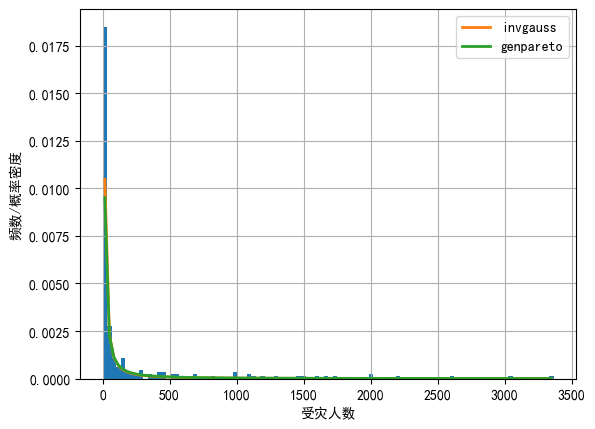


--- 对筛选后数据的拟合统计量 (按 sumsquare_error 升序排列) ---
           sumsquare_error          aic          bic  kl_div  ks_statistic  \
invgauss          0.000066  2186.416407  2196.968765     inf      0.119240   
genpareto         0.000082  2128.315148  2138.867507     inf      0.071081   

           ks_pvalue  
invgauss    0.001528  
genpareto   0.153902  

--- 对筛选后数据的最佳拟合分布 ---
按 sumsquare_error: {'invgauss': {'mu': 40.691556848432256, 'loc': -0.965000764762608, 'scale': 4.867045695125062}}
按 AIC: {'genpareto': {'c': 2.303222283978614, 'loc': 0.0006999999450553588, 'scale': 6.46994771277096}}
按 BIC: {'genpareto': {'c': 2.303222283978614, 'loc': 0.0006999999450553588, 'scale': 6.46994771277096}}

筛选后数据的最佳拟合分布 'invgauss' 的参数: {'mu': 40.691556848432256, 'loc': -0.965000764762608, 'scale': 4.867045695125062}


In [21]:

print(f"筛选后数据的描述:\n{data_to_fit.describe()}")

all_distributions = ['invgauss', 'genpareto']
f_filtered = Fitter(data_to_fit,
                    distributions=all_distributions,
                    timeout=120)

print("\n开始对筛选后的数据进行拟合...")
try:
    f_filtered.fit()
except Exception as e:
    print(f"对筛选后数据进行拟合时发生错误: {e}")
    print("可能是由于数据特性或所选分布不适用。")
    exit()

print("\n拟合结果摘要:")
f_filtered.summary()
# 图像输出
summary_df_filtered = f_filtered.summary(plot=True)
plt.xlabel(f"受灾人数")
plt.ylabel("频数/概率密度")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.savefig('拟合结果.png',dpi=900)
plt.show()

print(f"\n--- 对筛选后数据的拟合统计量 (按 sumsquare_error 升序排列) ---")
print(summary_df_filtered)

print(f"\n--- 对筛选后数据的最佳拟合分布 ---")
best_fit_sse_filtered = f_filtered.get_best(method='sumsquare_error')
print(f"按 sumsquare_error: {best_fit_sse_filtered}")

try:
    best_fit_aic_filtered = f_filtered.get_best(method='aic')
    print(f"按 AIC: {best_fit_aic_filtered}")
except KeyError:
    print("警告: 无法基于 AIC 获取筛选后数据的最佳拟合。")

try:
    best_fit_bic_filtered = f_filtered.get_best(method='bic')
    print(f"按 BIC: {best_fit_bic_filtered}")
except KeyError:
    print("警告: 无法基于 BIC 获取筛选后数据的最佳拟合。")

if best_fit_sse_filtered:
    best_dist_name_filtered = list(best_fit_sse_filtered.keys())[0]
    best_params_filtered = best_fit_sse_filtered[best_dist_name_filtered]
    print(f"\n筛选后数据的最佳拟合分布 '{best_dist_name_filtered}' 的参数: {best_params_filtered}")


In [18]:
import numpy as np
from scipy.stats import beta
from scipy.optimize import curve_fit# 定义 Beta 分布的 PDF 函数（包含位置和尺度参数）
def beta_pdf(x, a, b, loc, scale):
    return beta.pdf(x, a, b, loc=loc, scale=scale)
# 获取直方图数据（用于拟合）
hist, bin_edges = np.histogram(data, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# 拟合 Beta 分布
params, _ = curve_fit(
    beta_pdf, 
    bin_centers, 
    hist, 
    p0=[0.3, 587, 0.0007, 339378]  # 使用 fitter 返回的初始参数
)
# 输出拟合参数
print("拟合参数 (a, b, loc, scale):", params)
# 计算理论 PDF 和直方图的平方偏差
predicted_pdf = beta_pdf(bin_centers, *params)
sse = np.sum((hist - predicted_pdf)**2)
print("平方偏差 (SSE):", sse)

拟合参数 (a, b, loc, scale): [4.91818596e-02 1.56776528e+05 2.18426423e+02 2.85818714e+09]
平方偏差 (SSE): 1.7458724060614272e-09


In [19]:
import numpy as np
from scipy.stats import beta
# 使用 fitter 返回的参数
a, b, loc, scale = 0.3033, 587.9396, 0.0007, 339378.5966
# 生成理论 PDF（在数据范围内）
x = np.linspace(data.min(), data.max(), 1000)
theoretical_pdf = beta.pdf(x, a, b, loc=loc, scale=scale)
# 获取实际数据的直方图
hist, bin_edges = np.histogram(data, bins=1000, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# 计算平方偏差
predicted_pdf = beta.pdf(bin_centers, a, b, loc=loc, scale=scale)
sse = np.sum((hist - theoretical_pdf)**2)
print("平方偏差 (SSE):", sse)

平方偏差 (SSE): inf


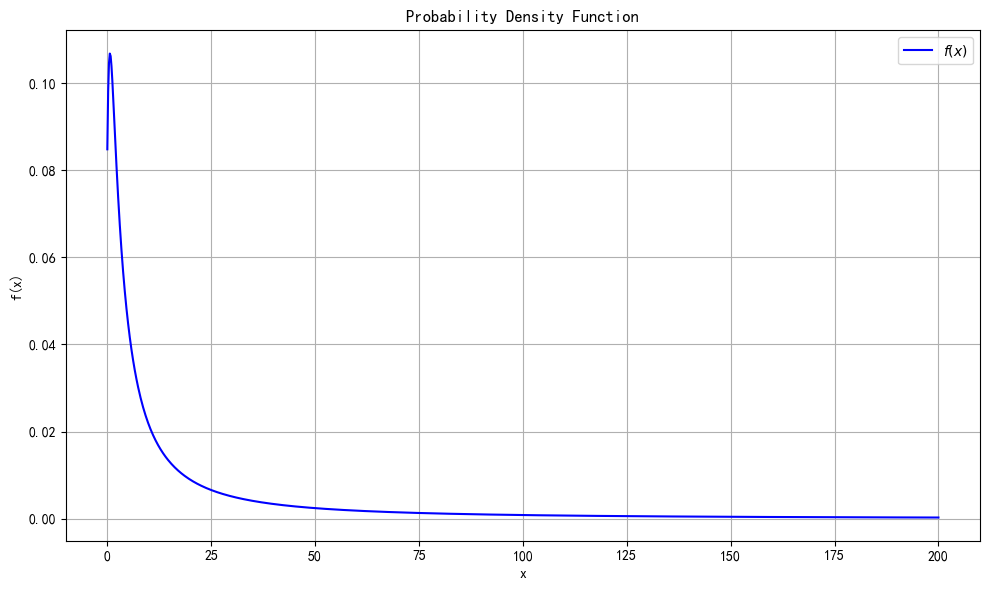

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 定义给定的概率密度函数
def f(x):
    A = 4.867045695125062
    mu = 40.691556848432256
    shift = 0.965000764762608
    denominator = (x + shift) ** 3
    exponent_numerator = A * ((x + shift) - mu) ** 2
    exponent_denominator = 2 * mu**2 * (x + shift)
    return np.sqrt(A / (2 * np.pi * denominator)) * np.exp(-exponent_numerator / exponent_denominator)

# 定义x的范围，避免x + shift为负或0
x = np.linspace(0.01, 200, 1000)
y = f(x)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=r'$f(x)$', color='blue')
plt.title('Probability Density Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
